In [1]:
# ======================== 0. Libraries ======================== #
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import keras_tuner as kt

In [2]:
# ======================== 1. Load and Prepare Data ======================== #
# Load
csvFilePath = 'data/aapl.csv'
df = pd.read_csv(csvFilePath)

# Drop Date (not a feature)
df = df.drop(columns=['Date', 'Scaled_sentiment'])

# Drop NaN rows (important after RSI/EMA indicators)
df = df.dropna()

print("✅ Data loaded and cleaned. Shape:", df.shape)

# Features and Target
features = df.drop(columns=['Close']).values   # All columns except Close
target = df['Close'].values.reshape(-1, 1)      # Only Close

# Scaling
scaler_X = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
target_scaled = scaler_y.fit_transform(target)

✅ Data loaded and cleaned. Shape: (685118, 6)


In [3]:
# ======================== 2. Create Sequences ======================== #

def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_all, y_all = create_sequences(features_scaled, target_scaled, time_steps)

print("✅ Sequences created:", X_all.shape, y_all.shape)

✅ Sequences created: (685058, 60, 5) (685058, 1)


In [4]:
# ======================== 3. Train/Test Split ======================== #

train_size = int(0.8 * len(X_all))

X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

print("✅ Train/Test Split:", X_train.shape, X_test.shape)

✅ Train/Test Split: (548046, 60, 5) (137012, 60, 5)


In [5]:
# ======================== 4. Define Build Model Function ======================== #
def build_model(hp):
    model = Sequential()
    
    model.add(Conv1D(
        filters=hp.Choice('filters_1', [128]),
        kernel_size=hp.Choice('kernel_size_1', [3]),
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(
        filters=hp.Choice('filters_2', [32]),
        kernel_size=hp.Choice('kernel_size_2', [2]),
        activation='relu'
    ))
    
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Dropout(rate=hp.Choice('dropout_rate', [0.2])))
    
    model.add(Flatten())
    
    model.add(Dense(
        hp.Choice('dense_units', [64])
    ))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Dense(1))  # Output layer

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', [1e-4])
    )
    
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

In [6]:
# ======================== 5. Setup Tuner ======================== #

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,   
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='cnn_close_price_prediction'
)

# Show search space
tuner.search_space_summary()

Reloading Tuner from keras_tuner_dir\cnn_close_price_prediction\tuner0.json
Search space summary
Default search space size: 7
filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
filters_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
kernel_size_2 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
dropout_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
dense_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [7]:
# ======================== 6. Search Best Model ======================== #

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

In [9]:
# ======================== 7. Get Best Model ======================== #

best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 58, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 28, 32)         │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,073 (152.63 KB)

 Trainable params: 39,073 (152.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# ======================== 8. Retrain Best Model ======================== #

# 4. Խելացի վերաուսուցում լավագույն մոդելի վրա՝ ամբողջ dataset-ի վրա
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_cnn_model.keras',
    save_best_only=True,
    monitor='val_loss'
)

# Ուսուցում ենք լավագույն մոդելը
history = best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=best_hyperparameters.values.get('batch_size', 32),
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_callback],
    verbose=1
)

Epoch 1/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 1.8626e-04 - val_loss: 3.1530e-05
Epoch 2/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - loss: 3.1059e-05 - val_loss: 4.1225e-05
Epoch 3/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 96s 7ms/step - loss: 2.3719e-05 - val_loss: 8.3909e-05
Epoch 4/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 87s 6ms/step - loss: 2.0162e-05 - val_loss: 1.8308e-04
Epoch 5/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 1.8191e-05 - val_loss: 2.2101e-04
Epoch 6/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 1.5890e-05 - val_loss: 6.8091e-04
Epoch 7/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 1.2780e-05 - val_loss: 8.3864e-04
Epoch 8/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 1.0708e-05 - val_loss: 8.3061e-04
Epoch 9/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 9.4084e-06 - val_loss: 7.9569e-04
Epoch 10/10
13702/13702 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 8.0035e-06 - val_loss: 0.0015


In [15]:
# ======================== 8. Evaluate Best Model ======================== #

# Predict
trainPredict = best_model.predict(X_train)
testPredict = best_model.predict(X_test)

# Inverse scaling
trainPredictInv = scaler_y.inverse_transform(trainPredict)
y_trainInv = scaler_y.inverse_transform(y_train)

testPredictInv = scaler_y.inverse_transform(testPredict)
y_testInv = scaler_y.inverse_transform(y_test)

# Metrics
train_mse = mean_squared_error(y_trainInv, trainPredictInv)
train_rmse = math.sqrt(train_mse)
train_mae = mean_absolute_error(y_trainInv, trainPredictInv)
train_r2 = r2_score(y_trainInv, trainPredictInv)

test_mse = mean_squared_error(y_testInv, testPredictInv)
test_rmse = math.sqrt(test_mse)
test_mae = mean_absolute_error(y_testInv, testPredictInv)
test_r2 = r2_score(y_testInv, testPredictInv)

print(f"✅ Training - MSE: {train_mse:.8f}, RMSE: {train_rmse:.8f}, MAE: {train_mae:.8f}, R2: {train_r2:.8f}")
print(f"✅ Testing  - MSE: {test_mse:.8f}, RMSE: {test_rmse:.8f}, MAE: {test_mae:.8f}, R2: {test_r2:.8f}")

17127/17127 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
4282/4282 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
✅ Training - MSE: 0.78959940, RMSE: 0.88859406, MAE: 0.69123760, R2: 0.99855136
✅ Testing  - MSE: 0.80639800, RMSE: 0.89799666, MAE: 0.70223079, R2: 0.99264397


In [24]:
# ======================== 9. Save Metrics ======================== #

metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'Value': [test_mse, test_rmse, test_mae, test_r2]
})

save_folder = f'test_result'
os.makedirs(save_folder, exist_ok=True)
metrics_df.to_csv(os.path.join(save_folder, 'aapl_nonsentiment_CNN_eval.csv'), index=False)

print("✅ Metrics saved at /mnt/data/cnn_best_model/evaluation_metrics.csv")

✅ Metrics saved at /mnt/data/cnn_best_model/evaluation_metrics.csv


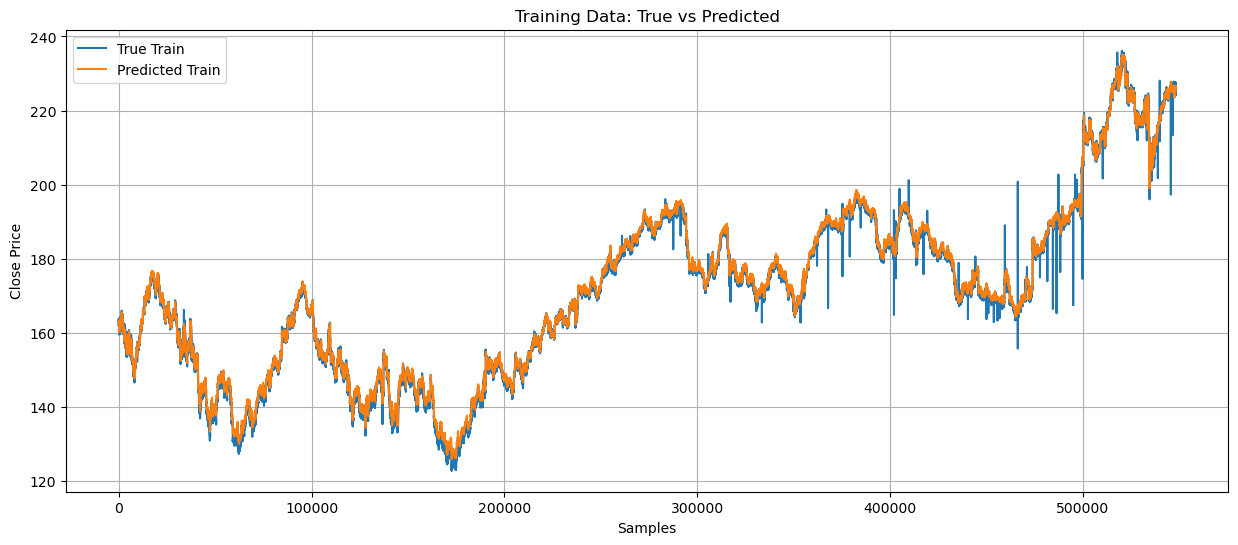

In [20]:
# ======================== 10. Visualizations ======================== #

# Loss history (tuner does not store history, but we can use callbacks later if needed)

# True vs Predicted (Train)
plt.figure(figsize=(15,6))
plt.plot(y_trainInv, label='True Train')
plt.plot(trainPredictInv, label='Predicted Train')
plt.title('Training Data: True vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

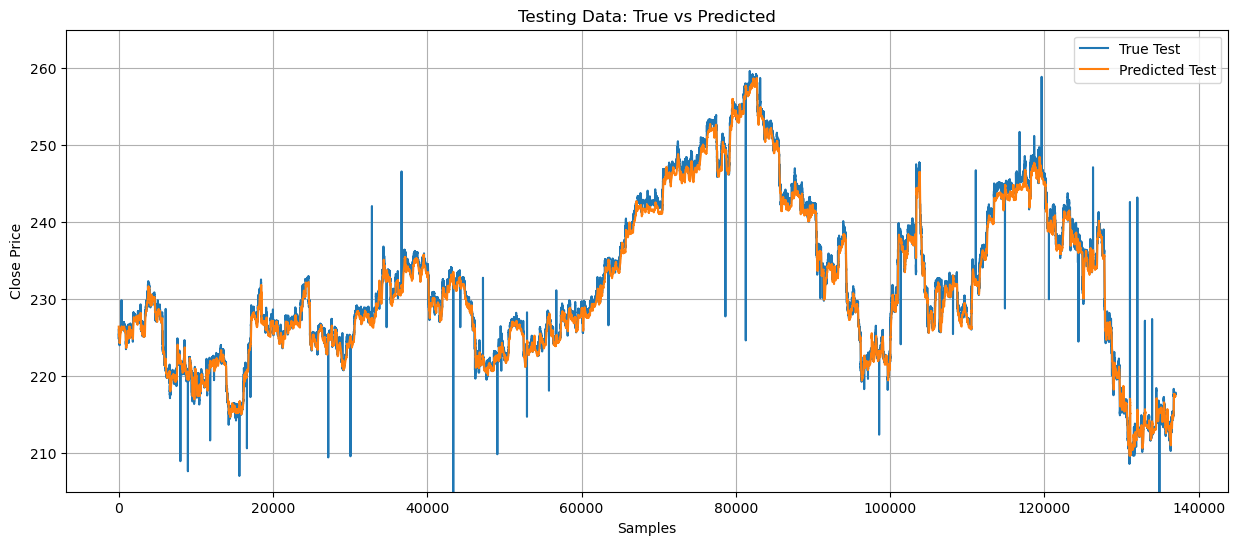

In [21]:
# True vs Predicted (Test)
plt.figure(figsize=(15,6))
plt.plot(y_testInv, label='True Test')
plt.plot(testPredictInv, label='Predicted Test')
plt.title('Testing Data: True vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.ylim(205, 265)  # Manual control
plt.legend()
plt.grid(True)
plt.show()

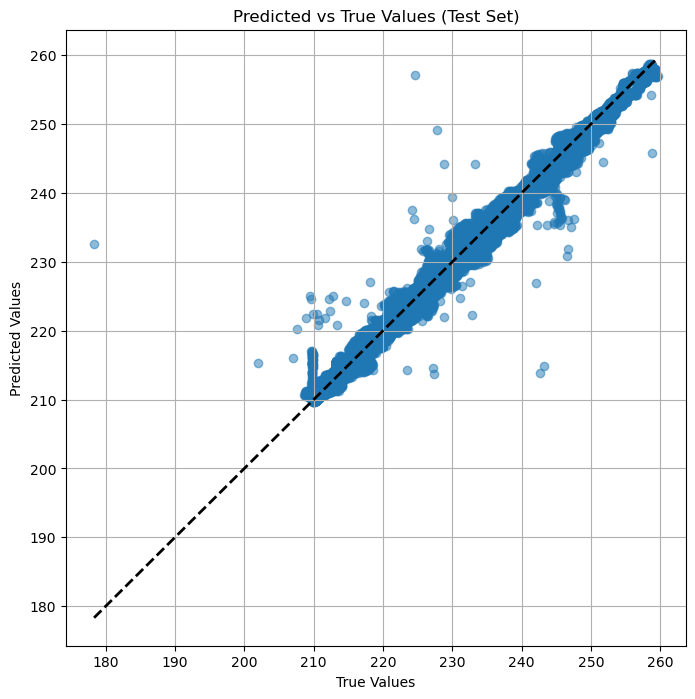

✅ Best model saved at /mnt/data/cnn_best_model/cnn_best_model.h5


In [22]:
# Scatter Plot (Test Set)
plt.figure(figsize=(8,8))
plt.scatter(y_testInv, testPredictInv, alpha=0.5)
plt.plot([y_testInv.min(), y_testInv.max()], [y_testInv.min(), y_testInv.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values (Test Set)')
plt.grid(True)
plt.show()

# ======================== 11. Save Best Model ======================== #

best_model.save(os.path.join(save_folder, 'cnn_best_model.h5'))
print("✅ Best model saved at /mnt/data/cnn_best_model/cnn_best_model.h5")


In [26]:
results_df = pd.DataFrame({
    'True_Test': y_testInv[:, 0],
    'Predicted_Test': testPredictInv[:, 0]
})

save_folder = f"test_result"
os.makedirs(save_folder, exist_ok=True)

save_path1 = os.path.join(save_folder, 'aapl_nonsentiment_CNN_pred.csv')
results_df.to_csv(save_path1, index=False)
print(f"✅ Test results saved successfully to {save_path1}")

✅ Test results saved successfully to test_result\aapl_nonsentiment_CNN_pred.csv
